In [52]:
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt
import json
import re
# from fbprophet import Prophet
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, SequentialSampler, RandomSampler
from torch.utils.data.distributed import DistributedSampler
import torch.nn.functional as F
from tqdm.autonotebook import trange, tqdm
# try:
#     from torch.utils.tensorboard import SummaryWriter
# except:
# from tensorboardX import SummaryWriter

In [6]:
key = 'G6IWTDY03TVAVHTK'
symbol = 'AMD'
interval = '1min'

In [7]:
# api_call = f'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol={symbol}&interval={interval}&outputsize=full&apikey={key}'
api_call = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={symbol}&outputsize=full&apikey={key}'

In [8]:
req = requests.get(api_call)

In [9]:
amd_ts = json.loads(req.text)

In [10]:
meta = amd_ts['Meta Data']

In [11]:
data = amd_ts['Time Series (Daily)']

In [12]:
meta

{'1. Information': 'Daily Prices (open, high, low, close) and Volumes',
 '2. Symbol': 'AMD',
 '3. Last Refreshed': '2020-01-28 12:21:34',
 '4. Output Size': 'Full size',
 '5. Time Zone': 'US/Eastern'}

In [13]:
amd_df = pd.DataFrame(data).T

In [14]:
amd_df.columns

Index(['1. open', '2. high', '3. low', '4. close', '5. volume'], dtype='object')

In [15]:
col_name = {'1. open': 'Open', '2. high': 'High', '3. low':'Low', '4. close': 'Close', '5. volume': 'Volume', 'index': 'Time'}
amd_df = amd_df.reset_index()
amd_df = amd_df.rename(columns=col_name)

In [16]:
amd_df.tail()

,Time,Open,High,Low,Close,Volume
5028,2000-02-01,36.5000,36.7500,35.0000,36.5600,2555600
5029,2000-01-31,35.2500,36.2500,34.4400,36.0000,2144400
5030,2000-01-28,37.1900,37.7500,34.3800,35.2500,3433600
5031,2000-01-27,38.0000,39.0000,36.8800,36.9400,3083900
5032,2000-01-26,37.6300,38.2500,36.5600,37.0000,3798900


In [17]:
amd_open = amd_df[['Time', 'Open']]
amd_open = amd_open.rename(columns={'Time':'ds', 'Open': 'y'})
# m = Prophet()
# m.fit(amd_open)
# future = m.make_future_dataframe(periods=420)

In [ ]:
# forecast = m.predict(future)

In [ ]:
# fig1 = m.plot(forecast)

In [ ]:
# amd_df.to_csv('amd_daily_data.csv')

In [53]:
class regressor(torch.nn.Module):
    def __init__(self):
        super(regressor, self).__init__()
        self.in_layer = nn.Linear(10, 32)
        self.layer_1 = nn.Linear(32, 16)
        self.layer_2 = nn.Linear(16, 4)
        self.output = nn.Linear(4, 1)
        
        self.ReLU = nn.ReLU()
        
        
    def forward(self, x):
        x = self.in_layer(x)
        x = self.ReLU(x)
        x = self.layer_1(x)
        x = self.ReLU(x)
        x = self.layer_2(x)
        x = self.ReLU(x)
        x = self.output(x)
        return x

In [54]:
reg_net = regressor()
reg_net = reg_net.float()
optimizer = torch.optim.Adam(reg_net.parameters(), lr=.0001)
criterion = torch.nn.MSELoss()

In [55]:
# Create autoregressive dataset
dataset = pd.concat([amd_open[['y']].rename(columns={'y': f'x_{i}'}).shift(i) for i in range(1, 11)], axis=1)
dataset.head()

,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,50.0300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,48.4500,50.0300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,52.2803,48.4500,50.0300,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,51.3400,52.2803,48.4500,50.0300,NaN,NaN,NaN,NaN,NaN,NaN


In [56]:
x = dataset.to_numpy()[10:].astype(np.double)
y = amd_open['y'].to_numpy()[10:].astype(np.double)

In [57]:
x.shape

(5023, 10)

In [58]:
y.shape

(5023,)

In [59]:
num_epochs = 10

In [60]:
for epoch in range(num_epochs):
    for xi, yi in zip(x, y):
        xt = torch.tensor(xi)
        yt = torch.tensor(yi)
        optimizer.zero_grad()
        estimate = reg_net(xt.float())
        loss = criterion(estimate, yt)
        loss.backward()
        optimizer.step()

In [78]:
reg_net(torch.tensor(x[0]).float())

AttributeError: 'builtin_function_or_method' object has no attribute 'numpy'

In [79]:
prediction = reg_net(torch.tensor(x).float())

In [86]:
pred = prediction.detach().numpy()

In [94]:
idx = list(amd_open['ds'])

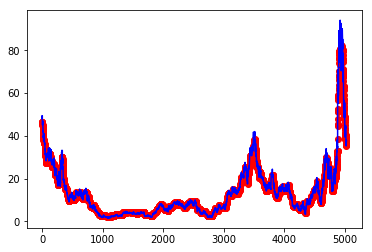

In [96]:
plt.plot(range(len(pred)), pred, 'ro')
plt.plot(range(len(y)), y, 'b')
plt.show()